In [66]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
array_8m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
awac_6m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-6m_202110.nc'

print(len(mission_list))

67


In [68]:
microSWIFT_sig_wave_heights_os = []
mission_times_os = []
awac_sig_wave_heights_os = []
num_waves_in_mission_os = []
standard_deviations_os = []
wave_heights_each_mission_os = []
array_8m_sig_wave_heights_os = []
awac_6m_sig_wave_heights_os = []
array_8m_Tm_os = []
awac_6m_Tm_os = []
average_x_loc_os = []
average_y_loc_os = []
array_8m_dir_os = []
total_drift_tracks = 0 

# Cross Shore Location for start of Breaking
bathy_dataset = nc.Dataset(bathy_file)

# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

# Based on Raubenheimer 1996 the average gamma value at Duck is approximately .35
gamma = 0.35

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    # Update total drift tracks
    total_drift_tracks += x_locations.shape[0]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)
    
    wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs,
                                                  wave_y_locs,
                                                  bathy_file)
    wave_heights_os = []
    wave_periods_os = []
    wave_x_loc_os = []
    wave_y_loc_os = []

    # Compute approximate cross shore location of surf zone 
    mission_hs = mission_tools.closest_awac_sig_wave_height(np.median(time), array_8m_file)

    # Compute depth that waves should be breaking in 
    mission_break_depth = mission_hs / gamma

    for n in np.arange(len(wave_bathy)):
        if wave_bathy[n] > -mission_break_depth:
            wave_heights_os.append(wave_heights[n])
            wave_x_loc_os.append(wave_x_locs[n])
            wave_y_loc_os.append(wave_y_locs[n])

    if len(wave_heights_os) > 30:
        wave_heights_each_mission_os.append(wave_heights_os)
        average_x_loc_os.append(np.mean(wave_x_loc_os))
        average_y_loc_os.append(np.mean(wave_y_loc_os))

        mission_time = np.median(mission_dataset['time'][:])
        mission_times_os.append(mission_time)
        num_waves_in_mission_os.append(len(wave_heights_os))
        awac_sig_wave_heights_os.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))
        array_8m_sig_wave_heights_os.append(mission_tools.closest_awac_sig_wave_height(mission_time, array_8m_file))
        awac_6m_sig_wave_heights_os.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_6m_file))
        array_8m_Tm_os.append(mission_tools.closest_awac_Tm(mission_time, array_8m_file))
        awac_6m_Tm_os.append(mission_tools.closest_awac_Tm(mission_time, awac_6m_file))
        array_8m_dir_os.append(mission_tools.closest_awac_dir(mission_time, array_8m_file))
    else:
        continue

In [69]:
print(f'The total number of drfit tracks in the dataset is {total_drift_tracks}')

The total number of drfit tracks in the dataset is 971


In [70]:
mission_times_date_os = cftime.num2pydate(mission_times_os,
                                          units=mission_dataset['time'].units,
                                          calendar=mission_dataset['time'].calendar)

# Compute the RMS wave height from the first sete of wave heights
ci_for_mission = []
rms_wave_height_for_mission = []

for n in range(len(mission_times_date_os)):
    wave_heights = np.array(wave_heights_each_mission_os[n])
    rms_wave_height = mission_tools.compute_rms_wave_height(wave_heights)
    rms_wave_height_for_mission.append(rms_wave_height)

    # Compute the 95% confidence interval for the RMS wave height using a bootstrap
    N = wave_heights.size
    ci_low = (rms_wave_height*1.414) * ((1 - 0.41)/np.sqrt(N))
    ci_high = (rms_wave_height*1.414) * ((1 + 0.41)/np.sqrt(N))
    
    # wave_heights = (wave_heights,) # data must be in a sequence for the bootstrap function
    # bootstrap_ci = stats.bootstrap(wave_heights, mission_tools.compute_rms_wave_height, confidence_level=0.95, method='percentile')
    # ci_low = bootstrap_ci.confidence_interval[0]
    # ci_high = bootstrap_ci.confidence_interval[1]
    ci_for_mission.append(ci_high - ci_low)

# Convert to numpy arrays
rms_wave_height_for_mission = np.array(rms_wave_height_for_mission)
hs_wave_height_for_mission = rms_wave_height_for_mission * 1.414
ci_for_mission = np.array(ci_for_mission)

In [71]:
# Along Shore Distance to Pier for the wave heights
# Pier is at a y location of 505 meters
alongshore_dist_to_pier = np.array([ (505 - y_loc) for y_loc in average_y_loc_os])

radial_dist_to_4p5awac = []
for n in range(len(average_x_loc_os)):
    radial_dist_to_4p5awac.append(np.sqrt((397.35 - average_x_loc_os[n])**2 +(890.98 - average_y_loc_os[n])**2))

radial_dist_to_4p5awac = np.array(radial_dist_to_4p5awac)
radius = 300
inds_in_awac_radius = np.where(radial_dist_to_4p5awac < radius)[0]
dist_in_radius = radial_dist_to_4p5awac[inds_in_awac_radius]
print(radial_dist_to_4p5awac.size)
print(dist_in_radius.size)

63
9


In [72]:
# Correct the 6 and 8 meter sensors to the the 4.5 m depth 
omega_8marray = 2 * np.pi / np.array(array_8m_Tm_os)
omega_6mawac = 2 * np.pi / np.array(awac_6m_Tm_os)
wavenumber_8marray = np.empty(omega_8marray.size)
wavenumber_8marray_os = np.empty(omega_8marray.size)
wavenumber_6mawac = np.empty(omega_6mawac.size)
wavenumber_6mawac_os = np.empty(omega_6mawac.size)

for n in range(wavenumber_8marray.size):
    wavenumber_8marray[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                    h=8,
                                                                    omega=omega_8marray[n])
    wavenumber_8marray_os[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                       h=4.8,
                                                                       omega=omega_8marray[n])
    wavenumber_6mawac[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                   h=6,
                                                                   omega=omega_6mawac[n])
    wavenumber_6mawac_os[n] = mission_tools.solve_dispersion_relation(g=9.8, 
                                                                      h=4.8,
                                                                      omega=omega_6mawac[n])

# Compute the group speed of at each station and at 4.8 meters
cg_8marray = mission_tools.compute_group_speed(wavenumber_8marray, 8)
cg_8marray_os = mission_tools.compute_group_speed(wavenumber_8marray_os, 4.8)
shoaling_coeff_8marray = np.sqrt(cg_8marray/cg_8marray_os)
array_8m_sig_wave_heights_os_shoaled = array_8m_sig_wave_heights_os * shoaling_coeff_8marray

cg_6mawac = mission_tools.compute_group_speed(wavenumber_6mawac, 6)
cg_6mawac_os = mission_tools.compute_group_speed(wavenumber_6mawac_os, 4.8)
shoaling_coeff_6mawac = np.sqrt(cg_6mawac/cg_6mawac_os)
awac_6m_sig_wave_heights_os_shoaled = awac_6m_sig_wave_heights_os * shoaling_coeff_6mawac

In [73]:
# Compute the root-mean-square-error between the microSWIFT arrays and the 4.5 m AWAC
def rmse(estimate, actual):
    return np.sqrt(np.mean(np.square(estimate - actual)))

rmse_microswifts = rmse(hs_wave_height_for_mission, awac_sig_wave_heights_os)
print(f'The RMSE for the microSWIFT significant wave heights is {np.round(rmse_microswifts, 3)} meters.')

# Adjust RMSE for the shoaling corrected Hs
rmse_8marray_shoaled = rmse(np.array(array_8m_sig_wave_heights_os_shoaled), awac_sig_wave_heights_os)
print(f'The RMSE for the 8m Array significant wave heights is {np.round(rmse_8marray_shoaled, 3)} meters.')

rmse_6mawac_shoaled = rmse(np.array(awac_6m_sig_wave_heights_os_shoaled), awac_sig_wave_heights_os)
print(f'The RMSE for the 6m AWAC significant wave heights is {np.round(rmse_6mawac_shoaled, 3)} meters.')

The RMSE for the microSWIFT significant wave heights is 0.37 meters.
The RMSE for the 8m Array significant wave heights is 0.092 meters.
The RMSE for the 6m AWAC significant wave heights is 0.071 meters.


2.475881615456798e-19
0.6134436967206452
0.7367284692198031


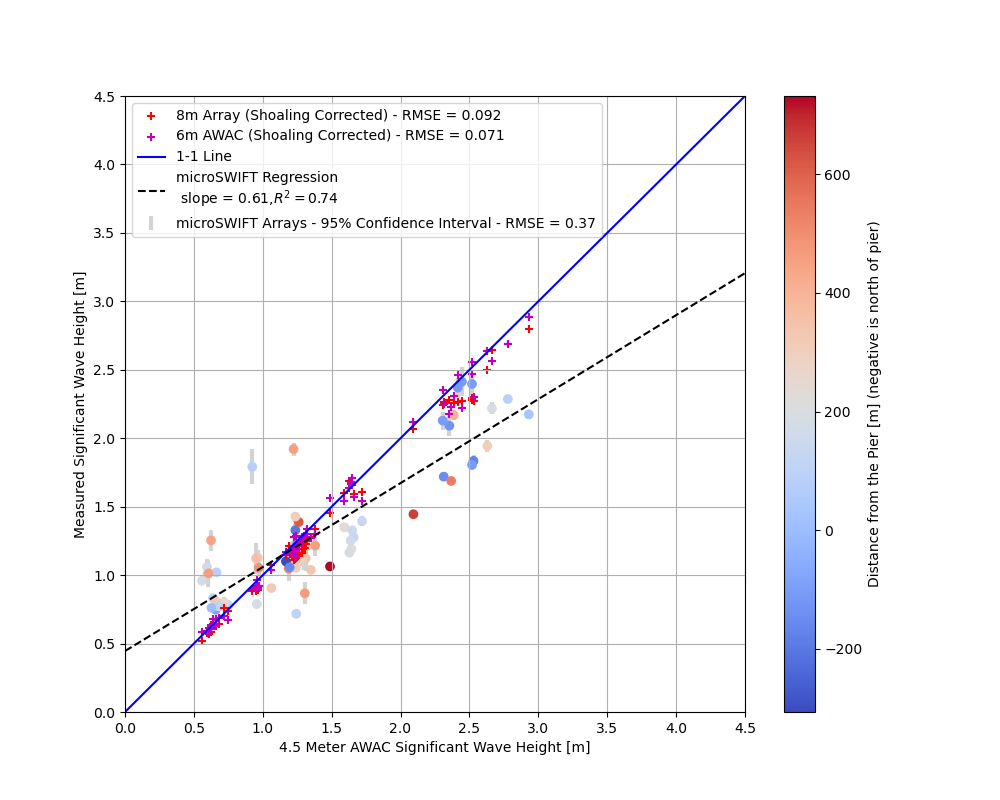

In [74]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope_os, \
intercept_os, \
r_value_os, \
p_value_os, \
std_err_os = stats.linregress(awac_sig_wave_heights_os, 
                              hs_wave_height_for_mission)
print(p_value_os)
x_os = np.linspace(0, 4.5)
y_os = slope_os * x_os + intercept_os

fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(awac_sig_wave_heights_os, hs_wave_height_for_mission, yerr=ci_for_mission, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
im = ax.scatter(awac_sig_wave_heights_os, hs_wave_height_for_mission, c=alongshore_dist_to_pier, cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Distance from the Pier [m] (negative is north of pier)')
ax.scatter(awac_sig_wave_heights_os, array_8m_sig_wave_heights_os_shoaled, color='r', marker='+', label=f'8m Array (Shoaling Corrected) - RMSE = {np.round(rmse_8marray_shoaled, 3)}')
ax.scatter(awac_sig_wave_heights_os, awac_6m_sig_wave_heights_os_shoaled, color='m', marker='+', label=f'6m AWAC (Shoaling Corrected) - RMSE = {np.round(rmse_6mawac_shoaled, 3)}')
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_os, y_os, color='k', linestyle='dashed', 
        label='microSWIFT Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope_os, r_value_os**2))
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)

print(slope_os)
print(r_value_os**2)

In [75]:
# Adjust wave direction to be relative to shore normal 
array_8m_dir_os_shore_norm = np.array(array_8m_dir_os) - 71.8
print(array_8m_dir_os_shore_norm)
print(array_8m_dir_os_shore_norm.size)
# NOTE: negative is from the north and positive is from the south

# Determine if the microSWIFT missions are in the shadow of the pier
in_pier_shadow = []
for n in range(alongshore_dist_to_pier.size):
    if np.abs(alongshore_dist_to_pier[n]) < 200:
        if np.abs(array_8m_dir_os_shore_norm[n]) > 5:
            in_pier_shadow.append(np.sign(alongshore_dist_to_pier[n] * array_8m_dir_os_shore_norm[n]))
        else:
            in_pier_shadow.append(1)
    else:
        in_pier_shadow.append(1)

in_pier_shadow = np.array(in_pier_shadow, dtype=int)
in_pier_shadow_inds = np.where(in_pier_shadow == -1)[0]
out_of_shadow_inds = np.where(in_pier_shadow == 1)[0]
print(in_pier_shadow.size)
print(in_pier_shadow_inds.size)
print(out_of_shadow_inds.size)

[  8.92818326 -13.20147821  -8.79234547   8.88059124 -13.10508667
 -39.15050625  -4.11013573  13.52183649  -4.86317578   3.7678363
   9.21275501 -14.83113032  -9.58707724   3.18048619 -11.32069799
  12.57631332  10.32636836 -11.79474545  -3.89762065  -4.0133223
 -41.75049476  28.60866471 -33.81067711  -9.04479805   8.67784012
 -12.93608324   2.17101881 -32.21948404  -9.31509702 -13.61819304
   8.81817076 -13.44060794   1.98343516  16.00027513   9.70042323
 -11.50587841  -2.06556061  -4.47831547 -12.62430483 -36.96854381
  -8.34668439   9.30078033   7.26935437 -14.76359349  13.0395805
   1.44376771 -33.86016677  -2.5412533  -40.20262918  -5.17543295
  30.65178526 -13.91889402   0.78682307 -11.67679127 -33.06740837
  -6.39477825 -13.05993449  -8.08549375 -34.87810404   8.56730494
 -15.29848952  12.9897973    1.30715182]
63
63
18
45


(0.0, 3.2)

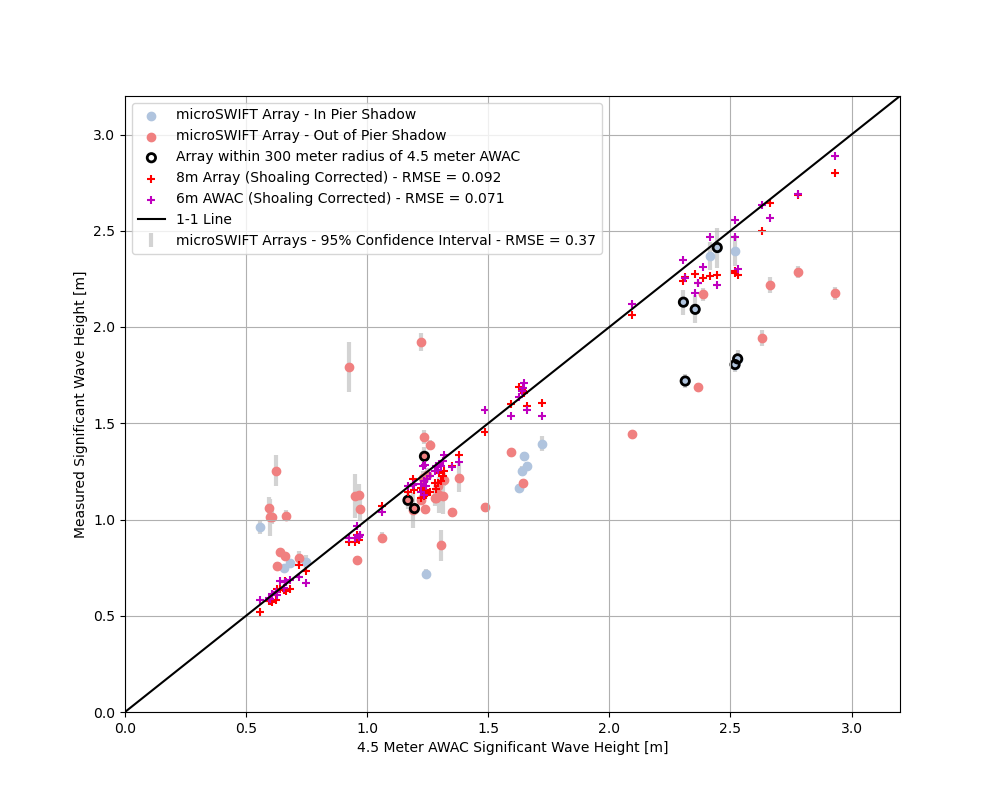

In [76]:
fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(awac_sig_wave_heights_os, hs_wave_height_for_mission, yerr=ci_for_mission, fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
ax.scatter(np.array(awac_sig_wave_heights_os)[in_pier_shadow_inds], np.array(hs_wave_height_for_mission)[in_pier_shadow_inds],
            color='lightsteelblue', label='microSWIFT Array - In Pier Shadow')
ax.scatter(np.array(awac_sig_wave_heights_os)[out_of_shadow_inds], np.array(hs_wave_height_for_mission)[out_of_shadow_inds],
            color='lightcoral', label='microSWIFT Array - Out of Pier Shadow')
ax.scatter(np.array(awac_sig_wave_heights_os)[inds_in_awac_radius], 
           np.array(hs_wave_height_for_mission)[inds_in_awac_radius], 
           facecolors='none', edgecolors='k', linewidths=2, label='Array within 300 meter radius of 4.5 meter AWAC')
ax.scatter(awac_sig_wave_heights_os, array_8m_sig_wave_heights_os_shoaled, color='r', marker='+', label=f'8m Array (Shoaling Corrected) - RMSE = {np.round(rmse_8marray_shoaled, 3)}')
ax.scatter(awac_sig_wave_heights_os, awac_6m_sig_wave_heights_os_shoaled, color='m', marker='+', label=f'6m AWAC (Shoaling Corrected) - RMSE = {np.round(rmse_6mawac_shoaled, 3)}')
ax.plot([0, 3.5], [0, 3.5], label='1-1 Line', color='k')
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 3.2)
ax.set_ylim(0, 3.2)

In [77]:
print(hs_wave_height_for_mission.size)
print(np.array(hs_wave_height_for_mission)[in_pier_shadow_inds].size)
print( np.array(hs_wave_height_for_mission)[~in_pier_shadow_inds].size)
print(in_pier_shadow_inds.size)

63
18
18
18


In [78]:
print(in_pier_shadow.size)
in_pier_shadow_inds = np.where(in_pier_shadow == -1)[0]
print(in_pier_shadow_inds)

63
[ 0  4  5 10 14 16 21 24 25 27 30 34 35 42 48 53 54 59]


(0.0, 3.2)

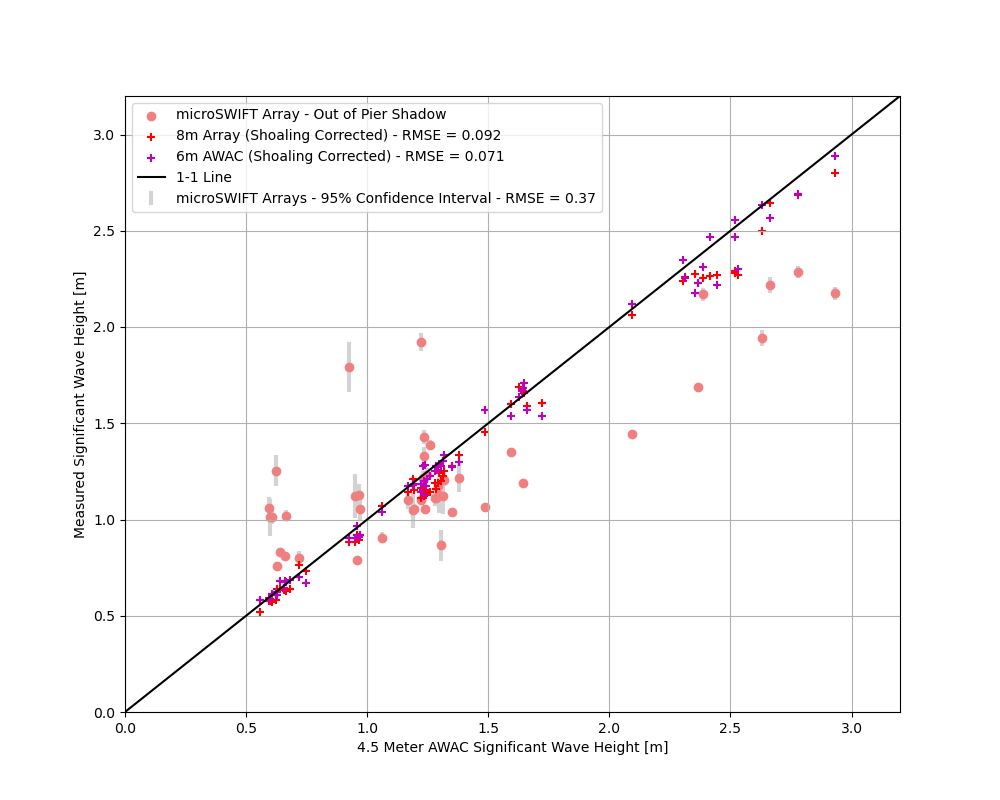

In [79]:
fig, ax = plt.subplots(figsize=(10,8))
ax.errorbar(np.array(awac_sig_wave_heights_os)[out_of_shadow_inds], 
            np.array(hs_wave_height_for_mission)[out_of_shadow_inds], 
            yerr=np.array(ci_for_mission)[out_of_shadow_inds], fmt='none', marker=None,
            ecolor='lightgray', elinewidth=3, capsize=0,
            label=f'microSWIFT Arrays - 95% Confidence Interval - RMSE = {np.round(rmse_microswifts, 3)}',
            zorder=0)
ax.scatter(np.array(awac_sig_wave_heights_os)[out_of_shadow_inds], np.array(hs_wave_height_for_mission)[out_of_shadow_inds],
            color='lightcoral', label='microSWIFT Array - Out of Pier Shadow')
ax.scatter(awac_sig_wave_heights_os, array_8m_sig_wave_heights_os_shoaled, color='r', marker='+', label=f'8m Array (Shoaling Corrected) - RMSE = {np.round(rmse_8marray_shoaled, 3)}')
ax.scatter(awac_sig_wave_heights_os, awac_6m_sig_wave_heights_os_shoaled, color='m', marker='+', label=f'6m AWAC (Shoaling Corrected) - RMSE = {np.round(rmse_6mawac_shoaled, 3)}')
ax.plot([0, 3.5], [0, 3.5], label='1-1 Line', color='k')
ax.set_ylabel('Measured Significant Wave Height [m]')
ax.set_xlabel('4.5 Meter AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 3.2)
ax.set_ylim(0, 3.2)

In [80]:
# Compute linear regression between the microSWIFT arrays and the AWAC - ommitting all in shadow points
slope_os_out_of_shadow, \
intercept_os_out_of_shadow, \
r_value_os_out_of_shadow, \
p_value_os_out_of_shadow, \
std_err_os_out_of_shadow = stats.linregress(np.array(awac_sig_wave_heights_os)[out_of_shadow_inds], 
                                            np.array(hs_wave_height_for_mission)[out_of_shadow_inds])

print(f'Slope of regression using only out of shadow points {slope_os_out_of_shadow}')

Slope of regression using only out of shadow points 0.5392526765961674


In [81]:
# compute percent reduction of sample size when ommitting shadowed points.
percent_of_total = out_of_shadow_inds.size/len(hs_wave_height_for_mission) * 100
print(f'Percent of total missions that are out of shadown {percent_of_total}')

Percent of total missions that are out of shadown 71.42857142857143
